# Testing and evaluating the performance

This notebook focuses on testing and evaluating the performance of your genetic algorithm models developed for dynamic pricing. It would typically include:

- Model Implementation: Code to implement and configure your genetic algorithms and other models.
- Parameter Tuning: Experiments with different parameters and settings for your models to optimize performance.
- Model Evaluation: Using various metrics to evaluate the performance of your models. This could include measuring accuracy, precision, recall, or any other relevant metrics.
- Validation: Applying cross-validation or other techniques to ensure that your model generalizes well to unseen data.
- Visualization of Results: Creating charts or graphs to visually represent the performance of your models, such as convergence over time, comparison between different models, etc.
- Insights and Conclusions: Drawing conclusions from the model testing about what works well and what might need further improvement.

In [87]:
import pandas as pd
from deap import base, creator, tools, algorithms
import json
import datetime
import random
import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

data = pd.read_csv('../data/Travel.csv')

# Load and preprocess data
data['startDate'] = pd.to_datetime(data['startDate'], unit='s')
data['endDate'] = pd.to_datetime(data['endDate'], unit='s')
data['month'] = data['startDate'].dt.month-1
data['day_of_week'] = data['startDate'].dt.dayofweek
data['hour_of_day'] = data['startDate'].dt.hour

data[['startDate', 'endDate', 'month', 'day_of_week', 'hour_of_day']]

,startDate,endDate,month,day_of_week,hour_of_day
0,2019-10-20 18:13:55,2019-10-21 07:13:55,9,6,18
1,2019-07-19 09:49:00,2019-07-19 23:49:00,6,4,9
2,2018-12-27 01:31:26,2018-12-27 22:31:26,11,3,1
3,2019-07-20 05:42:31,2019-07-21 03:42:31,6,5,5
4,2019-11-05 02:22:54,2019-11-05 05:22:54,10,1,2
...,...,...,...,...,...
315,2018-11-22 20:58:28,2018-11-22 22:58:28,10,3,20
316,2018-12-18 11:28:49,2018-12-18 18:28:49,11,1,11
317,2019-06-17 12:15:46,2019-06-17 12:15:46,5,0,12
318,2019-03-05 01:52:22,2019-03-05 14:52:22,2,1,1


# Demand prediction as an optimization problem
goal is to find the best combination of features to minimize the prediction error

## Problem for GA
demand prediction as an optimization problem where the goal is to find the best combination of features

## Represent Solutions
Each individual in the GA population could represent a set of features derived from historical data

## Fitness Function
fitness function should measure how well an individual predicts demand

## Genetic Operations
genetic operators (selection, crossover, mutation), crossover might combine features from two parent individuals, and mutation might slightly alter a feature

## Best Solution for Current Demand Prediction
based on historical data, can be used to predict current demand

In [202]:
import datetime

# Aggregate data for basic demand patterns
avg_monthly_demand = data.groupby('month').size()
avg_daily_demand = data.groupby('day_of_week').size()
avg_hourly_demand = data.groupby('hour_of_day').size()

today = datetime.datetime.now()
today_month = today.month
today_day = today.weekday()
today_hour = today.hour

# Simple average
current_demand_estimate = (avg_monthly_demand[today_month - 1] +
                       avg_daily_demand[today_day] +
                       avg_hourly_demand[today_hour]) / 3

print("Simple Average Demand for Today:", current_demand_estimate)

Simple Average Demand for Today: 29.0


In [88]:
import random
import datetime
import asyncio
from deap import base, creator, tools, algorithms
import random

RANDOM_SEED = 42
random.seed(RANDOM_SEED)

class DemandPredictor:
    def __init__(self, data):
        self.data = data
        self.avg_monthly_demand = data.groupby('month').size()
        self.avg_daily_demand = data.groupby('day_of_week').size()
        self.avg_hourly_demand = data.groupby('hour_of_day').size()

        # Clear existing classes if they exist
        if "FitnessMax" in creator.__dict__:
            del creator.FitnessMax
        if "Individual" in creator.__dict__:
            del creator.Individual

        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)

        self.toolbox = base.Toolbox()
        self.toolbox.register("individual", self.create_individual)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)
        self.toolbox.register("evaluate", self.evaluate)
        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
        self.toolbox.register("select", tools.selTournament, tournsize=3)

    def create_individual(self):
        return creator.Individual([random.uniform(0.5, 1.5) for _ in range(3)])

    def evaluate(self, individual):
        mse = 0
        count = 0
        for _, row in self.data.iterrows():
            predicted_demand = (self.avg_monthly_demand[row['month']] * individual[0] +
                                self.avg_daily_demand[row['day_of_week']] * individual[1] +
                                self.avg_hourly_demand[row['hour_of_day']] * individual[2])
            # Actual demand from your historical or actual demand data
            actual_demand = (self.avg_monthly_demand[row['month']] +
                             self.avg_daily_demand[row['day_of_week']] +
                             self.avg_hourly_demand[row['hour_of_day']])
            mse += (actual_demand - predicted_demand) ** 2
            count += 1
        mse /= count
        return -mse,

    def run_ga(self):
        population = self.toolbox.population(n=50)
        hof = tools.HallOfFame(1)
        stats = tools.Statistics(key=lambda ind: ind.fitness.values)
        stats.register("avg", np.mean)
        stats.register("min", np.min)
        stats.register("max", np.max)
        algorithms.eaSimple(population, self.toolbox, 0.7, 0.2, 30, stats=stats, halloffame=hof, verbose=False)
        return hof.items[0]

    def get_predicted_demand(self):
        best_solution = self.run_ga()
        today = datetime.datetime.now()
        today_month = today.month
        today_day = today.weekday()
        today_hour = today.hour

        predicted_demand_today = (self.avg_monthly_demand[today_month - 1] * best_solution[0] +
                                  self.avg_daily_demand[today_day] * best_solution[1] +
                                  self.avg_hourly_demand[today_hour] * best_solution[2])/3
        return max(predicted_demand_today, 0)



predictor = DemandPredictor(data)
predicted_demand = predictor.get_predicted_demand()
print("Predicted Demand for Today:", predicted_demand)

Predicted Demand for Today: 32.62959371535434


# Weather conditions as optimization problem

In [85]:
from deap import base, creator, tools, algorithms
import random

class WeatherMultiplierPredictor:
    def __init__(self, seed=42, multipliers_range=(0.8, 1.2), population_size=100, generations=50):
        self.seed = seed
        self.multipliers_range = multipliers_range
        self.population_size = population_size
        self.generations = generations
        self.setup()

    def setup(self):
        random.seed(self.seed)

        # Clear existing classes if they exist
        if "FitnessMax" in creator.__dict__:
            del creator.FitnessMax
        if "Individual" in creator.__dict__:
            del creator.Individual

        # Define the individual (multiplier set) structure
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMax)

        self.toolbox = base.Toolbox()
        self.toolbox.register("attr_multiplier", random.uniform, *self.multipliers_range)
        self.toolbox.register("individual", tools.initRepeat, creator.Individual, self.toolbox.attr_multiplier, n=4)
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)

        self.toolbox.register("evaluate", self.evaluate)
        self.toolbox.register("mate", tools.cxUniform, indpb=0.1)
        self.toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.1)
        self.toolbox.register("select", tools.selBest)

    def evaluate(self, individual):
        # fitness function based on expert knowledge
        temperature_mult, wind_speed_mult, rain_snow_mult, humidity_mult = individual
    
        # Demand fluctuations based on weather conditions
        temperature_effect = 1.1 if random.random() < 0.1 else 1.0  # 10% chance of hot/cold affecting demand
        wind_speed_effect = 0.95 if random.random() < 0.05 else 1.0  # 5% chance of wind affecting demand
        rain_snow_effect = 1.2 if random.random() < 0.2 else 1.0  # 20% chance of rain/snow affecting demand
        humidity_effect = 0.9 if random.random() < 0.1 else 1.0  # 10% chance of high humidity affecting demand

         # Apply multipliers to the demand effects
        simulated_revenue = (temperature_mult * temperature_effect +
                         wind_speed_mult * wind_speed_effect +
                         rain_snow_mult * rain_snow_effect +
                         humidity_mult * humidity_effect)
    
        # In a real model, you would also consider costs, competition, and other factors
        return simulated_revenue,

    def run(self):
        population = self.toolbox.population(n=self.population_size)

        for gen in range(self.generations):
            offspring = algorithms.varAnd(population, self.toolbox, cxpb=0.5, mutpb=0.2)
            fits = self.toolbox.map(self.toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit
            population = self.toolbox.select(offspring, k=len(population))

        best_individual = tools.selBest(population, k=1)[0]
        return best_individual, best_individual.fitness.values

# Example usage
optimizer = WeatherMultiplierPredictor()
best_individual, best_fitness = optimizer.run()
print("Best Multiplier Set:", best_individual)
print("Best Fitness:", best_fitness)

Best Multiplier Set: [1.2769456962453005, 1.0709271781090932, 1.6953029263364474, 1.3379932796230358]
Best Fitness: (5.455317291032952,)


# Dynamic price predication as an optimization problem

- Demand: Higher demand could increase the price.
- Customer Loyalty: Loyal customers might get discounts.
- Time/Day: Prices might vary depending on peak and off-peak hours/days.
- Weather: Bad weather might increase demand and prices.
- Remoteness: More remote areas might have higher or lower prices based on demand and availability.

In [30]:
from deap import base, creator, tools, algorithms
import random

# Clear existing classes if they exist
if "FitnessMax" in creator.__dict__:
    del creator.FitnessMax
if "Individual" in creator.__dict__:
    del creator.Individual

random.seed(43)

# Constants
BASE_PRICE = 50
LOYALTY_DISCOUNT = 0.9  # 10% discount
WEATHER_SURCHARGE = 1.2  # 20% surcharge for bad weather
WEEKEND_SURCHARGE = 1.1  # 10% surcharge for weekends
REMOTENESS_SURCHARGE = 1.15  # 15% surcharge for remote areas

# Define the objective function
def calculate_price(individual):
    demand_modifier, loyalty_modifier, weather_modifier, day_modifier, remoteness_modifier = individual

    price = BASE_PRICE
    price *= demand_modifier
    price *= LOYALTY_DISCOUNT if customer_loyalty else 1
    price *= WEATHER_SURCHARGE if weather_condition == "bad" else 1
    price *= WEEKEND_SURCHARGE if day_of_week >= 4 else 1
    price *= REMOTENESS_SURCHARGE if remoteness else 1

    return price,

# Define the problem - Maximize the price
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0.8, 1.2)  # Modifiers between 80% and 120%
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=5)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", calculate_price)
toolbox.register("mate", tools.cxBlend, alpha=0.1)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# Input parameters
customer_loyalty = 0
weather_condition = "bad"
day_of_week = 0
remoteness = 1

# Genetic Algorithm parameters
population_size = 100
num_generations = 50

# Create initial population
population = toolbox.population(n=population_size)

# Enforce realistic bounds after crossover and mutation
def enforce_bounds(individual):
    for i in range(len(individual)):
        individual[i] = max(0.8, min(1.2, individual[i]))
    return individual

# Run the genetic algorithm
for gen in range(num_generations):
    # Select the next generation individuals
    offspring = toolbox.select(population, len(population))
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # Apply crossover and mutation on the offspring
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Enforce bounds after crossover and mutation
    for individual in offspring:
        enforce_bounds(individual)

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Replace the old population by the offspring
    population[:] = offspring


# Best solution
best_ind = tools.selBest(population, 1)[0]
best_price = calculate_price(best_ind)[0]

print("Best price:", best_price)
print("Best individual:", best_ind)

# Calculate profit
profit = round(best_price-BASE_PRICE,2)
print("Profit:", profit)
profit_percentage = round((best_price-BASE_PRICE)/BASE_PRICE,2)
print("Profit %:",profit_percentage)

Best price: 82.8
Best individual: [1.2, 0.9266033948460778, 1.0081589802769315, 1.0949956964017131, 0.9649762688572285]
Profit: 32.8
Profit %: 0.66


# Profit as an optimization problem

In [32]:
import random
from deap import base, creator, tools, algorithms

# Constants (these would be based on your business data)
BASE_PRICE = 50
LOYALTY_DISCOUNT = 0.05  # 5% discount for loyal customers
REMOTE_COST_FACTOR = 0.1  # 10% additional cost for remoteness
WEATHER_DEMAND_IMPACT = 0.2  # 20% decrease in demand due to bad weather

def calculate_final_price(strategy):
    # Unpack the strategy
    demand = strategy[1]
    weather = 'bad' if strategy[2] > 0.5 else 'good'
    loyalty = strategy[3] > 0.5
    remoteness = strategy[4]

    # Calculate base price based on demand
    price = demand_price(demand)

    # Adjust for weather
    price = weather_adjustment(price, weather)

    # Adjust for customer loyalty
    price = loyalty_adjustment(price, loyalty)

    # Add cost for remoteness
    final_price = remoteness_cost(price, remoteness)

    return final_price

# Example functions to calculate price based on different factors
def demand_price(demand):
    return BASE_PRICE * demand

def weather_adjustment(price, weather):
    if weather == 'bad':
        return price * (1 - WEATHER_DEMAND_IMPACT)
    return price

def loyalty_adjustment(price, loyalty):
    if loyalty:
        return price * (1 - LOYALTY_DISCOUNT)
    return price

def remoteness_cost(price, remoteness):
    return price + remoteness * REMOTE_COST_FACTOR * price

def calculate_profit(individual):
    price = individual[0]
    demand = individual[1]
    weather = 'bad' if individual[2] > 0.5 else 'good'
    loyalty = individual[3] > 0.5
    remoteness = individual[4]

    # Calculate base price based on demand
    price = demand_price(demand)

    # Adjust for weather
    price = weather_adjustment(price, weather)

    # Adjust for customer loyalty
    price = loyalty_adjustment(price, loyalty)

    # Add cost for remoteness
    price = remoteness_cost(price, remoteness)

    # Assuming profit is simply the final price (for simplicity)
    return price

# Fitness function
def evaluate(individual):
    profit = calculate_profit(individual)
    cci = 0.33  # Keeping CCI static for simplicity

    if cci < 0.33:
        return -999999,  # Penalty for low CCI
    return profit,

# Genetic algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 1)  # Random values for demand, weather, loyalty, remoteness
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=5)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0.5, sigma=0.2, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize population
population = toolbox.population(n=300)

# Genetic Algorithm Parameters
NGEN = 40
CXPB, MUTPB = 0.5, 0.2

# Running the Genetic Algorithm
for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, CXPB, MUTPB)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Best Pricing Strategy
best_ind = tools.selBest(population, 1)[0]
print("Best Strategy:", best_ind)

# Calculate the final price for strategy
final_price = calculate_final_price(best_ind)
print("Final Price to Customer:", final_price)

# Calculate profit
print("Profit:", final_price-BASE_PRICE)
print("Profit %:", (final_price-BASE_PRICE)/BASE_PRICE)

Best Strategy: [2.6248429894815417, 8.741306921036774, 0.12440285709910315, 0.22916623367892175, 5.001322027773183]
Final Price to Customer: 655.6558003303757
Profit: 605.6558003303757
Profit %: 12.113116006607513


# OneMax Problem

In [318]:
import random
from deap import algorithms, base, creator, tools

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def evalOneMax(individual):
    return (sum(individual),)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=100)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

if __name__ == "__main__":
    pop = toolbox.population(n=300)
    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, verbose=False)
    print(tools.selBest(pop, k=1))

[[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


# Genetic Programming

mul(mul(x, x), sub(x, x))


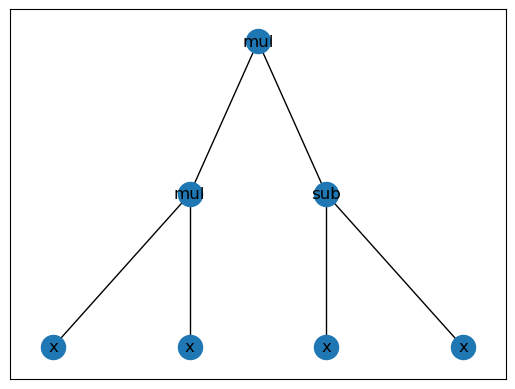

In [18]:
from deap import base, creator, gp
import networkx as nx
import pylab as plt
from networkx.drawing.nx_agraph import graphviz_layout

# Clear existing classes if they exist
if "FitnessMax" in creator.__dict__:
    del creator.FitnessMax
if "Individual" in creator.__dict__:
    del creator.Individual

pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.renameArguments(ARG0='x')

creator.create("Individual", gp.PrimitiveTree)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)

expr = toolbox.individual()
nodes, edges, labels = gp.graph(expr)

print(expr)

g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos = nx.nx_agraph.graphviz_layout(g, prog="dot")

nx.draw_networkx_nodes(g, pos)
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels)
plt.show()